## Make a sentinel 2 time series for field plots

The following runs a few python functions to extract Sentinel 2 NDVI time series data from a point GIS files using google earth engine (GEE) and geopandas. This is potentially useful for looking at temporal patterns of NDVI for comparison with other variables and the spatial patterns therein. 

The example is running on countryside survey data which may be accessed via the CEH environmental data centre. Though any geopandas readable point file should work. **Adjust the input dates according to your requirements.**

https://eip.ceh.ac.uk/

The data is returned as a dataframe as well as written to file and can be easily plotted using pandas native functions.

In [ ]:
from src.s2timeseries import S2_ts,_points_to_pixel, plot_group
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

Read in a point shapefile and define a name for the new one. 

**Please obtain the field survey data from CEH**

In [ ]:
inShp = 'pathtomyfile.shp'

outfile = 'example_NDVI_S2.shp'

gdf = gpd.read_file(inShp)

#sanity check
gdf.head()

Quickly plot the coords....

In [ ]:
# Sanity check 2.....
uk = gpd.read_file("uk.shp")

base = uk.plot(color='white', edgecolor='black', figsize=(8, 8))

gdf.plot(ax=base, marker='o', color='red', markersize=5);


The point coordinates should be converted to lat/lon for GEE if not in this format already. 
As this is a UK example we are going from OSGB to lat/lon.


In [4]:
lons, lats = _points_to_pixel(gdf, espgin='epsg:27700', espgout='epsg:4326')

### Now to get the time series

This returns a new geo-dataframe which includes the time series data as a variable and also writes a file to disk. 

The reason for inputting the original gdf from above is to retain the correct index for the shapefile for writing purposes. The secondary reason for this procedure is to avoid uploading any data to GEE directly, thus it is just anonamous coordinates.

Some messages will appear updating progress of the task. 

Key params (most are self explanatory)
- ```dist=20``` (the distance in metres from the point - for S2 either 10 or 20)
- ```stat=max``` (the aggregate stat from which monthly NDVI is derived - either ```max``` or ```perc``` where perc is 95th percentile
- ```collection="COPERNICUS/S2"``` (the collection in question - for the year of interest we are limited to the TOA product, but for 2017 onwards the ```"COPERNICUS/S2_SR"``` or L2A surface reflectance are available.

The cloud mask is not being used as there is a tendency to lose more data values than is necessary. 


In [5]:
newdf = S2_ts(lons, lats, gdf, collection="COPERNICUS/S2", start_date='2016-01-01',
      end_date='2016-12-31', dist=20, cloud_mask=False, stat='max', 
      cloud_perc=100, para=True, outfile=outfile)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1336 out of 1336 | elapsed:  2.8min finished


Have a look and see the ndvi vals are there as expected - they will be under date headings.

In [ ]:
newdf.head()

Now with a new gpd it is easy enough to plot the spatial pattern of ndvi. 

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 10))

dates = ["2016-03-31", "2016-05-31", "2016-11-30"]

for idx, d in enumerate(dates):

    newdf.plot(column=d, ax=axes[idx], legend=True, legend_kwds={'orientation': "horizontal"})


### Having processed gained ndvi attributes, it is easy to plot the ndvi time series with a bit of reshaping per survey area

As we are using survey data where plots are grouped by the attribute "SQUARE", we can plot the ndvi time series for with a function in src with the function from src.
```python
plot_group(newdf, 'SQUARE', 637, '2016')
```
Where:
- ```SQUARE``` = the attribute to group by
- ```637``` = the index of interest
- ```2016``` =  the year of interest

It is more than likely the dips in values are due to the presence of clouds, which could be removed by some sort of filtering on the df or directly during the time series download.


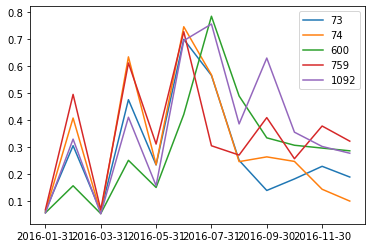

In [4]:
plot_group(newdf, 'SQUARE', 637, '2016')

If you wish to see the possible square values to plot see below

**This is of course unique to CS plots, but minor adaption could make it work for another attribute**

In [ ]:
np.unique(newdf.SQUARE)

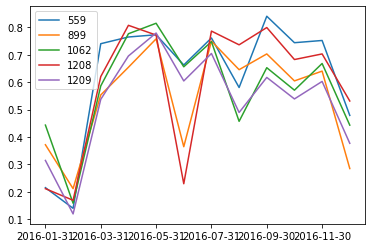

In [5]:
plot_group(newdf, 'SQUARE', 15, '2016')